#How did the COVID-19 pandemic impact ABC Company’s parcel business?

#•	When were customer volumes first impacted by COVID-19?

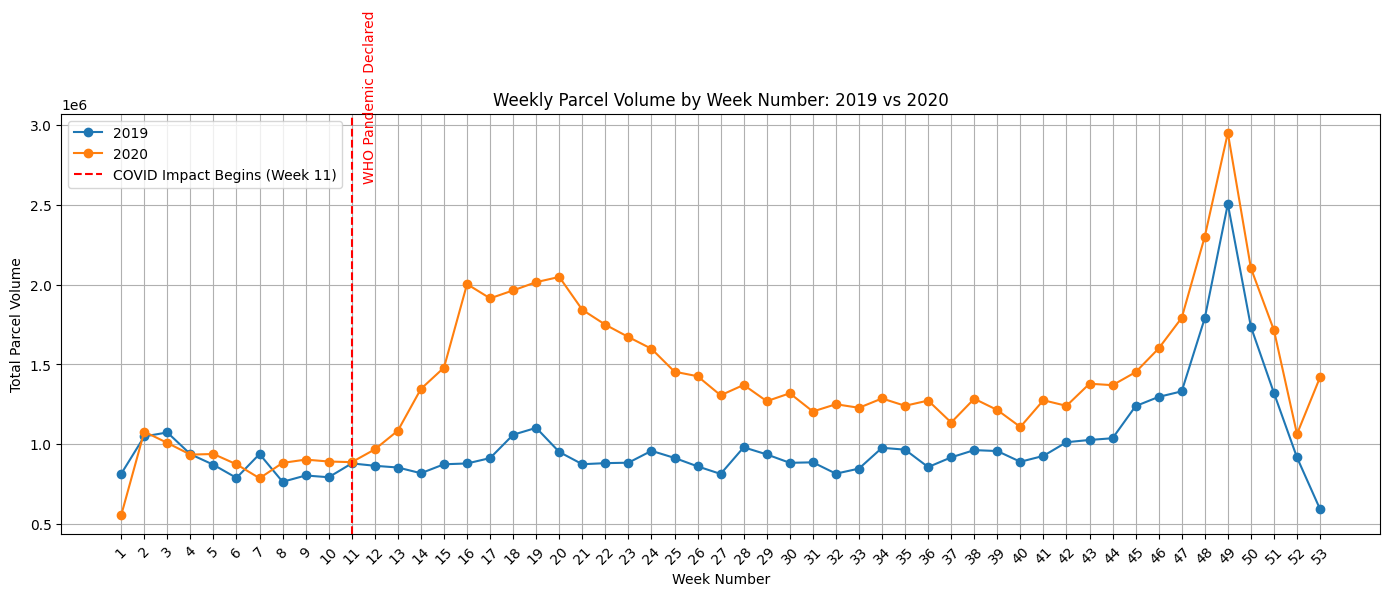

In [37]:
# Plot using week numbers on the x-axis and show all week numbers explicitly
plt.figure(figsize=(14, 6))
plt.plot(volume_2019['THE_WEEK'], volume_2019['VOLUME'], label='2019', marker='o')
plt.plot(volume_2020['THE_WEEK'], volume_2020['VOLUME'], label='2020', marker='o')

# Add vertical line for COVID pandemic declaration week
covid_week = 11
plt.axvline(covid_week, color='red', linestyle='--', label='COVID Impact Begins (Week 11)')
plt.text(covid_week + 0.5, weekly_volume['VOLUME'].max() * 0.9, "WHO Pandemic Declared", rotation=90, color='red')

# Show all week numbers (1–53)
plt.xticks(ticks=range(1, 54), labels=[str(w) for w in range(1, 54)], rotation=45)

plt.title("Weekly Parcel Volume by Week Number: 2019 vs 2020")
plt.xlabel("Week Number")
plt.ylabel("Total Parcel Volume")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#What events within the COVID timeline may have contributed to the change?

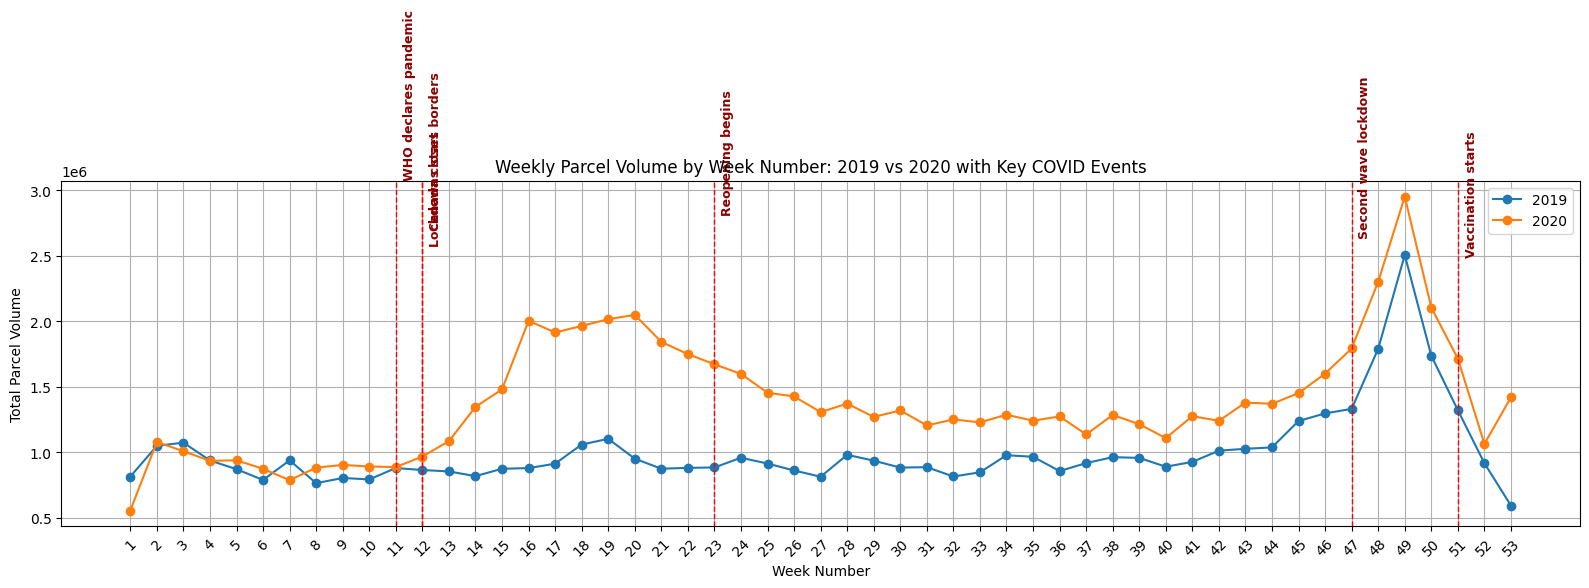

In [36]:
# Plot with all weeks explicitly shown on the x-axis

plt.figure(figsize=(16, 6))
plt.plot(volume_2019['THE_WEEK'], volume_2019['VOLUME'], label='2019', marker='o')
plt.plot(volume_2020['THE_WEEK'], volume_2020['VOLUME'], label='2020', marker='o')

# Annotate key COVID events
event_weeks = [
    ("WHO declares pandemic", 11),
    ("Canada closes borders", 12),
    ("Lockdowns start", 12),
    ("Reopening begins", 23),
    ("Second wave lockdown", 47),
    ("Vaccination starts", 51)
]
alt_positions = [1.05, 0.92, 0.88, 0.96, 0.90, 0.85]
max_vol = weekly_volume['VOLUME'].max()

for i, (event, week) in enumerate(event_weeks):
    plt.axvline(week, color='red', linestyle='--', linewidth=1)
    y_pos = max_vol * alt_positions[i]
    plt.text(week + 0.5, y_pos, event, rotation=90, fontsize=9, color='darkred', fontweight='bold', ha='center')

# Set full week range for clarity
plt.xticks(ticks=range(1, 54), labels=[str(w) for w in range(1, 54)], rotation=45)

plt.title("Weekly Parcel Volume by Week Number: 2019 vs 2020 with Key COVID Events")
plt.xlabel("Week Number")
plt.ylabel("Total Parcel Volume")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#•	How did COVID-19 impact peak season in 2020?

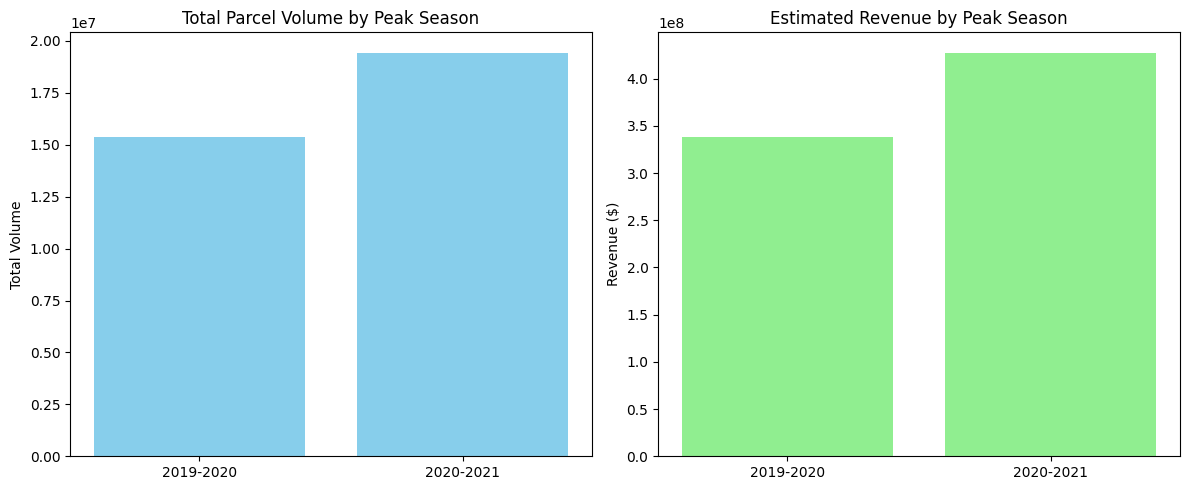

,Peak Season,Total Volume,Estimated Revenue ($),Volume Growth (%),Revenue Growth (%)
0,2019-2020,15372691,338199202.0,NaN,NaN
1,2020-2021,19442907,427743954.0,26.48,26.48


In [31]:
# Re-run the summary creation and plotting without using ace_tools

# Recompute the percentage growth
volume_growth = ((peak_season_summary.loc[1, 'Total Volume'] - peak_season_summary.loc[0, 'Total Volume']) /
                 peak_season_summary.loc[0, 'Total Volume']) * 100

revenue_growth = ((peak_season_summary.loc[1, 'Estimated Revenue ($)'] - peak_season_summary.loc[0, 'Estimated Revenue ($)']) /
                  peak_season_summary.loc[0, 'Estimated Revenue ($)']) * 100

# Add to the DataFrame
peak_season_summary['Volume Growth (%)'] = [None, round(volume_growth, 2)]
peak_season_summary['Revenue Growth (%)'] = [None, round(revenue_growth, 2)]

# Plotting the results
plt.figure(figsize=(12, 5))

# Bar plot for Total Volume
plt.subplot(1, 2, 1)
plt.bar(peak_season_summary['Peak Season'], peak_season_summary['Total Volume'], color='skyblue')
plt.title("Total Parcel Volume by Peak Season")
plt.ylabel("Total Volume")

# Bar plot for Estimated Revenue
plt.subplot(1, 2, 2)
plt.bar(peak_season_summary['Peak Season'], peak_season_summary['Estimated Revenue ($)'], color='lightgreen')
plt.title("Estimated Revenue by Peak Season")
plt.ylabel("Revenue ($)")

plt.tight_layout()
plt.show()

# Display updated summary DataFrame
peak_season_summary


#•	How has COVID affected companies in the different customer groups (Enterprise, Large, etc.)?

In [39]:
# Fix: Drop duplicated Customer_Group columns before merging again

# Step 1: Remove any previous conflicting group columns
df = df.drop(columns=[col for col in df.columns if col.startswith('Customer_Group')], errors='ignore')

# Step 2: Classify customers based on 2020 pre-COVID (Weeks 1–15) volume
pre_covid_2020 = df[(df['THE_YEAR'] == 2020) & (df['THE_WEEK'] <= 15)]
pre_covid_volume = pre_covid_2020.groupby('FakeCustomerID')['VOLUME'].sum().reset_index()
pre_covid_volume.columns = ['FakeCustomerID', 'Pre_COVID_2020_Volume']

def classify_customer(volume):
    if volume >= 10000:
        return 'Enterprise'
    elif volume >= 1000:
        return 'Large'
    elif volume >= 100:
        return 'Medium'
    else:
        return 'Small'

pre_covid_volume['Customer_Group'] = pre_covid_volume['Pre_COVID_2020_Volume'].apply(classify_customer)

# Step 3: Merge classification into main dataframe
df = df.merge(pre_covid_volume[['FakeCustomerID', 'Customer_Group']], on='FakeCustomerID', how='left')

# Step 4: Filter COVID-period data (Weeks 16–53)
covid_2019 = df[(df['THE_YEAR'] == 2019) & (df['THE_WEEK'] > 15)].copy()
covid_2020 = df[(df['THE_YEAR'] == 2020) & (df['THE_WEEK'] > 15)].copy()

# Step 5: Aggregate by customer group
group_2019 = covid_2019.groupby('Customer_Group').agg({'VOLUME': 'sum'}).rename(columns={'VOLUME': '2019_Volume'}).reset_index()
group_2019['2019_Revenue ($)'] = group_2019['2019_Volume'] * 22

group_2020 = covid_2020.groupby('Customer_Group').agg({'VOLUME': 'sum'}).rename(columns={'VOLUME': '2020_Volume'}).reset_index()
group_2020['2020_Revenue ($)'] = group_2020['2020_Volume'] * 22

# Step 6: Merge and calculate changes
covid_group_comparison = pd.merge(group_2019, group_2020, on='Customer_Group', how='outer').fillna(0)
covid_group_comparison['Volume Change (%)'] = (
    (covid_group_comparison['2020_Volume'] - covid_group_comparison['2019_Volume']) /
    covid_group_comparison['2019_Volume'].replace(0, 1)
) * 100
covid_group_comparison['Revenue Change ($)'] = covid_group_comparison['2020_Revenue ($)'] - covid_group_comparison['2019_Revenue ($)']

# Step 7: Round and sort
covid_group_comparison = covid_group_comparison.round(2)
covid_group_comparison = covid_group_comparison.sort_values(by='2020_Volume', ascending=False)

covid_group_comparison


,Customer_Group,2019_Volume,2019_Revenue ($),2020_Volume,2020_Revenue ($),Volume Change (%),Revenue Change ($)
0,Enterprise,36074853,793646766,53710276,1181626072,48.89,387979306
1,Large,2564656,56422432,3897272,85739984,51.96,29317552
2,Medium,949508,20889176,1163118,25588596,22.50,4699420
3,Small,67846,1492612,62827,1382194,-7.40,-110418


#•	What percent of each customer group is growing, moderately growing, and declining during the COVID observation period?

In [12]:
# Reuse the volume_by_customer dataframe and merge it with the customer group info
volume_by_customer_grouped = volume_by_customer.merge(
    pre_covid_volume[['FakeCustomerID', 'Customer_Group']],
    on='FakeCustomerID',
    how='left'
)

# Remove customers without a defined group
volume_by_customer_grouped = volume_by_customer_grouped.dropna(subset=['Customer_Group'])

# Group by Customer_Group and Growth_Label
group_growth_distribution = volume_by_customer_grouped.groupby(
    ['Customer_Group', 'growth_label']
)['FakeCustomerID'].count().reset_index()

# Pivot for easier percentage calculation
pivot_dist = group_growth_distribution.pivot(index='Customer_Group', columns='growth_label', values='FakeCustomerID').fillna(0)

# Calculate row-wise percentage
pivot_dist_percent = pivot_dist.div(pivot_dist.sum(axis=1), axis=0) * 100

# Round and reset for display
pivot_dist_percent = pivot_dist_percent.round(2).reset_index()
pivot_dist_percent


growth_label,Customer_Group,Declining,High Growth,Moderate Growth
0,Enterprise,5.75,94.25,0.00
1,Large,6.65,91.76,1.60
2,Medium,8.93,90.35,0.73
3,Small,33.33,66.67,0.00


#•	What percent of each customer group are new customers during the COVID observation period?

In [13]:
# Count new customers by group
new_customers = volume_by_customer_grouped[volume_by_customer_grouped['growth_label'] == 'New']

# Total customers per group
total_customers_per_group = volume_by_customer_grouped.groupby('Customer_Group')['FakeCustomerID'].count().reset_index()
total_customers_per_group.columns = ['Customer_Group', 'Total_Customers']

# Merge with new customer counts
new_counts = new_customers.groupby('Customer_Group')['FakeCustomerID'].count().reset_index()
new_counts.columns = ['Customer_Group', 'New_Customers']

# Combine and compute percentages
new_percent_summary = pd.merge(total_customers_per_group, new_counts, on='Customer_Group', how='left').fillna(0)
new_percent_summary['New Customer %'] = (new_percent_summary['New_Customers'] / new_percent_summary['Total_Customers']) * 100
new_percent_summary = new_percent_summary.round(2)

new_percent_summary


,Customer_Group,Total_Customers,New_Customers,New Customer %
0,Enterprise,87,0.0,0.0
1,Large,376,0.0,0.0
2,Medium,549,0.0,0.0
3,Small,27,0.0,0.0


#•	What percent of 2019 customers in each group did we lose during the COVID observation period?

In [14]:
# Step 1: Identify customers active in 2019 (any week)
active_2019 = df[df['THE_YEAR'] == 2019]['FakeCustomerID'].unique()

# Step 2: Identify customers active during COVID (Week 16+ of 2020)
active_covid = df[(df['THE_YEAR'] == 2020) & (df['THE_WEEK'] > 15)]['FakeCustomerID'].unique()

# Step 3: Lost customers = Active in 2019 but NOT active during COVID
lost_customer_ids = set(active_2019) - set(active_covid)

# Step 4: Get group info for lost customers
lost_customers_grouped = pre_covid_volume[pre_covid_volume['FakeCustomerID'].isin(lost_customer_ids)]

# Count lost customers per group
lost_counts = lost_customers_grouped.groupby('Customer_Group')['FakeCustomerID'].nunique().reset_index()
lost_counts.columns = ['Customer_Group', 'Lost_Customers']

# Step 5: Total 2019 customers per group (from pre_covid_volume)
total_2019_group = pre_covid_volume.groupby('Customer_Group')['FakeCustomerID'].nunique().reset_index()
total_2019_group.columns = ['Customer_Group', 'Total_2019_Customers']

# Step 6: Merge and calculate percent lost
lost_summary = pd.merge(total_2019_group, lost_counts, on='Customer_Group', how='left').fillna(0)
lost_summary['Lost Customer %'] = (lost_summary['Lost_Customers'] / lost_summary['Total_2019_Customers']) * 100
lost_summary = lost_summary.round(2)

lost_summary


,Customer_Group,Total_2019_Customers,Lost_Customers,Lost Customer %
0,Enterprise,87,0.0,0.00
1,Large,376,2.0,0.53
2,Medium,549,7.0,1.28
3,Small,27,6.0,22.22


#What was the overall impact of COVID on volumes and revenue by customer group?

In [15]:
# Step 1: COVID period data (Week 16+ of 2020)
covid_period_df = df[(df['THE_YEAR'] == 2020) & (df['THE_WEEK'] > 15)]

# Step 2: Pre-COVID period data (Weeks 1–15 of 2020)
pre_covid_period_df = df[(df['THE_YEAR'] == 2020) & (df['THE_WEEK'] <= 15)]

# Step 3: Aggregate pre- and covid-period volume by customer group
pre_covid_grouped = pre_covid_period_df.groupby('Customer_Group')['VOLUME'].sum().reset_index()
pre_covid_grouped.columns = ['Customer_Group', 'Pre_COVID_Volume']

covid_grouped = covid_period_df.groupby('Customer_Group')['VOLUME'].sum().reset_index()
covid_grouped.columns = ['Customer_Group', 'COVID_Volume']

# Step 4: Merge and compute revenue
impact_summary = pd.merge(pre_covid_grouped, covid_grouped, on='Customer_Group', how='outer').fillna(0)
impact_summary['Pre_COVID_Revenue ($)'] = impact_summary['Pre_COVID_Volume'] * 22.00
impact_summary['COVID_Revenue ($)'] = impact_summary['COVID_Volume'] * 22.00
impact_summary['Volume_Change (%)'] = ((impact_summary['COVID_Volume'] - impact_summary['Pre_COVID_Volume']) / impact_summary['Pre_COVID_Volume']) * 100
impact_summary['Revenue_Change ($)'] = impact_summary['COVID_Revenue ($)'] - impact_summary['Pre_COVID_Revenue ($)']

impact_summary = impact_summary.round(2)
impact_summary


,Customer_Group,Pre_COVID_Volume,COVID_Volume,Pre_COVID_Revenue ($),COVID_Revenue ($),Volume_Change (%),Revenue_Change ($)
0,Enterprise,13245903,53710276,291409866.0,1.181626e+09,305.49,890216206.0
1,Large,1084686,3897272,23863092.0,8.573998e+07,259.30,61876892.0
2,Medium,287299,1163118,6320578.0,2.558860e+07,304.85,19268018.0
3,Small,1129,62827,24838.0,1.382194e+06,5464.84,1357356.0


In [32]:
# Filter pre-COVID period (weeks 1–15) for both 2019 and 2020
pre_covid_2019 = df[(df['THE_YEAR'] == 2019) & (df['THE_WEEK'] <= 15)]
pre_covid_2020 = df[(df['THE_YEAR'] == 2020) & (df['THE_WEEK'] <= 15)]

# Group by customer group and summarize volume
group_2019 = pre_covid_2019.groupby('Customer_Group')['VOLUME'].sum().reset_index()
group_2019.columns = ['Customer_Group', '2019_Volume']

group_2020 = pre_covid_2020.groupby('Customer_Group')['VOLUME'].sum().reset_index()
group_2020.columns = ['Customer_Group', '2020_Volume']

# Merge and calculate volume and revenue comparison
pre_covid_comparison = pd.merge(group_2019, group_2020, on='Customer_Group', how='outer').fillna(0)
pre_covid_comparison['2019_Revenue ($)'] = pre_covid_comparison['2019_Volume'] * 22.00
pre_covid_comparison['2020_Revenue ($)'] = pre_covid_comparison['2020_Volume'] * 22.00
pre_covid_comparison['Volume_Change (%)'] = ((pre_covid_comparison['2020_Volume'] - pre_covid_comparison['2019_Volume']) / pre_covid_comparison['2019_Volume']) * 100
pre_covid_comparison['Revenue_Change ($)'] = pre_covid_comparison['2020_Revenue ($)'] - pre_covid_comparison['2019_Revenue ($)']

pre_covid_comparison = pre_covid_comparison.round(2)
pre_covid_comparison


,Customer_Group,2019_Volume,2020_Volume,2019_Revenue ($),2020_Revenue ($),Volume_Change (%),Revenue_Change ($)
0,Enterprise,11794365,13245903,259476030.0,291409866.0,12.31,31933836.0
1,Large,922864,1084686,20303008.0,23863092.0,17.53,3560084.0
2,Medium,331735,287299,7298170.0,6320578.0,-13.40,-977592.0
3,Small,18592,1129,409024.0,24838.0,-93.93,-384186.0


In [33]:
# Proceed using 'FakeCustomerID' as the grouping field for comparison

# Filter pre-COVID period (weeks 1–15) for both 2019 and 2020
pre_covid_2019 = df[(df['THE_YEAR'] == 2019) & (df['THE_WEEK'] <= 15)]
pre_covid_2020 = df[(df['THE_YEAR'] == 2020) & (df['THE_WEEK'] <= 15)]

# Group by FakeCustomerID and summarize volume
group_2019 = pre_covid_2019.groupby('FakeCustomerID')['VOLUME'].sum().reset_index()
group_2019.columns = ['FakeCustomerID', '2019_Volume']

group_2020 = pre_covid_2020.groupby('FakeCustomerID')['VOLUME'].sum().reset_index()
group_2020.columns = ['FakeCustomerID', '2020_Volume']

# Merge and calculate volume and revenue comparison
pre_covid_comparison = pd.merge(group_2019, group_2020, on='FakeCustomerID', how='outer').fillna(0)
pre_covid_comparison['2019_Revenue ($)'] = pre_covid_comparison['2019_Volume'] * 22.00
pre_covid_comparison['2020_Revenue ($)'] = pre_covid_comparison['2020_Volume'] * 22.00
pre_covid_comparison['Volume_Change (%)'] = ((pre_covid_comparison['2020_Volume'] - pre_covid_comparison['2019_Volume']) / pre_covid_comparison['2019_Volume'].replace(0, 1)) * 100
pre_covid_comparison['Revenue_Change ($)'] = pre_covid_comparison['2020_Revenue ($)'] - pre_covid_comparison['2019_Revenue ($)']

pre_covid_comparison = pre_covid_comparison.round(2)
pre_covid_comparison.head(10)  # Show top 10 for preview


,FakeCustomerID,2019_Volume,2020_Volume,2019_Revenue ($),2020_Revenue ($),Volume_Change (%),Revenue_Change ($)
0,100771,442.0,448.0,9724.0,9856.0,1.36,132.0
1,102180,1365.0,828.0,30030.0,18216.0,-39.34,-11814.0
2,102643,745.0,599.0,16390.0,13178.0,-19.60,-3212.0
3,102750,344.0,196.0,7568.0,4312.0,-43.02,-3256.0
4,103308,19560.0,23748.0,430320.0,522456.0,21.41,92136.0
5,103862,693.0,1179.0,15246.0,25938.0,70.13,10692.0
6,104216,595.0,671.0,13090.0,14762.0,12.77,1672.0
7,104298,41264.0,28471.0,907808.0,626362.0,-31.00,-281446.0
8,105129,433.0,319.0,9526.0,7018.0,-26.33,-2508.0
9,105157,481.0,571.0,10582.0,12562.0,18.71,1980.0
